# Enriched Max-P regionalization and the FaCT algorithm
**Authors:Yunfan Kang**

The `max-p-enriched` problem involves clustering a set of geographic areas into the maximum number of homogeneous regions that satisfies a set of user defined constraints. Different from the `max-p` regions ([Duque, Anselin, Rey (2012)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9787.2011.00743.x)) problem, EMP formulation supports 5 aggregates: MIN, MAX, AVG, SUM, and COUNT. Each aggregate can be paired with a range operator and each query can contain any subset of the five aggregates.

This notebook demonstrate the algorithm proposed in [Kang and Magdy (2021)]() .

In [2]:
import pyneapple.regionalization.emp as emp
import pyneapple.weight.rook as rook
import libpysal 
import time
from libpysal.weights import Queen, Rook, KNN, Kernel, DistanceBand
import numpy as np
import geopandas
import pandas
import matplotlib.pyplot as plt
import jpype
from jpype import java
from jpype import javax

Matplotlib is building the font cache; this may take a moment.
Fontconfig warning: ignoring UTF-8: not a valid region tag


To demonstrate `max-p-enriched`, we combine the census tracts of the Los Angeles City with facts about population and employment status. The plot shows the dataset with the areas colored by its population in 2010.

In [3]:
path = "data/LACity/LACity.shp"
lacity = geopandas.read_file(path)

<Axes: >

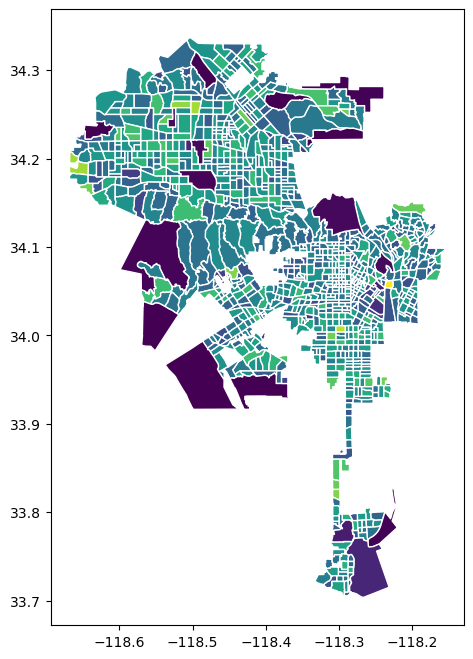

In [4]:
lacity.plot(column = 'pop2010', figsize = (12, 8), edgecolor = 'w')


In [5]:
lacity.head()

,fid,OBJECTID,TRACTCE10,POP,LATPOP_D,WHIPOP_D,BLAPOP_D,AMIPOP_D,ASIPOP_D,HPIPOP_D,...,Tot_Housin,Occup_Hous,Vac_Housin,GEO.id,pop2010,households,pop_16up,employed,unemployed,geometry
0,1.0,1,101110,4731,1324,2656,83,24,580,15,...,1734.0,1641.0,93.0,1400000US06037101110,5017,1693,3954,2512,175,"POLYGON ((-118.29420 34.26289, -118.29331 34.2..."
1,2.0,2,101122,3664,575,2437,34,18,578,3,...,1369.0,1325.0,44.0,1400000US06037101122,3663,1304,3042,1932,102,"POLYGON ((-118.28996 34.27813, -118.29006 34.2..."
2,3.0,3,101210,5990,2219,2890,192,16,625,16,...,2317.0,2150.0,167.0,1400000US06037101210,6799,2175,5370,3317,307,"POLYGON ((-118.29212 34.25071, -118.29219 34.2..."
3,4.0,4,101220,3363,1272,1662,45,25,335,6,...,1317.0,1246.0,71.0,1400000US06037101220,3189,1173,2631,1620,153,"POLYGON ((-118.27946 34.24757, -118.27976 34.2..."
4,5.0,5,101300,4199,503,3190,47,26,402,10,...,1582.0,1542.0,40.0,1400000US06037101300,3808,1408,3209,1857,151,"POLYGON ((-118.26542 34.25547, -118.26542 34.2..."


Because `Pineapple` is a Java-based library, to make use of the functions we need to set up a JVM to execute the Java codes.

In [6]:
jpype.startJVM("-Xmx20480m", classpath = ["./Pineapple.jar"])

To formulate a `max-p-enriched` problem, a number of parameters need to be specified.

Firstly, a [spatial weights object](https://pysal.org/libpysal/tutorial.html) needs to be calculated. The Pineapple package provides a module `Pineapple.weight.rook` that is supposed to give the same result as the `libpysal.weights.Rook` but runs faster espicially when the number of areas is large.

In [7]:
w = rook.from_dataframe(lacity)

1012


Then, we can formulate the query by specifying the constraints and the dissimilarity attribute. 

For the first example query, we show how a `max-p` query by formulating it as an `max-p-enriched` query. We use the model to aggregate the cencus tracts in Los Angeles city into regions with population >= 200000 and the heterogeneity mesured by the number of households in each area is minimized.

In [8]:
sum_attr = 'pop2010'
sum_low = 200000.0
dis_attr = 'households'

We then pass the parameters to the module `Pineapple.regionalization.emp`. For the unused constraints, the attribute can be specified as any arbitrary attribute and the range is set to be (-infinity, infinity)

In [9]:
non_attr = 'pop_16up'
inf = java.lang.Double.POSITIVE_INFINITY
p, regions = emp.emp(lacity, w, dis_attr, non_attr, -inf, inf, non_attr, -inf, inf, non_attr, -inf, inf, sum_attr, sum_low, inf, -inf, inf) 

17


The number of regions, i.e. the p value, and the region label of each area is returned after the regionalization computation.

In [10]:
p

17

In [11]:
regions

array([ 43,  43,  43, ..., 933, 985, 933], dtype=int32)

<Axes: >

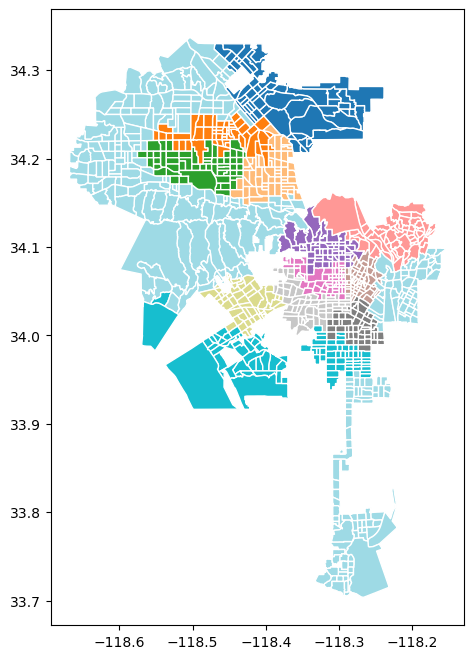

In [12]:
lacity["regionLabel"] = regions
lacity.plot(column = "regionLabel", cmap="tab20", edgecolor="w", figsize = (12, 8))

Next, we forlulate a query with multiple constraints: aggregate the cencus tracts in Los Angeles city into regions with `population >= 20000`, the minimum `labor force per area <= 3000`, average `employed population between 1500 and 3500`, and the heterogeneity mesured by the number of households in each area is minimized.
Similar to the previous example, we just need to specify the attribute for each constraint and the coresponding range.

In [16]:
min_attr = 'pop_16up'
min_high = 3000.0
avg_attr = 'employed'
avg_low = 1000.0
avg_high = 4000.0
sum_attr = 'pop2010'
sum_low = 20000.0
dis_attr = 'households'

In [17]:
non_attr = 'pop_16up'
inf = java.lang.Double.POSITIVE_INFINITY
p, regions = emp.emp(lacity, w, dis_attr, min_attr, -inf, min_high, non_attr, -inf, inf, avg_attr, avg_low, avg_high, sum_attr, sum_low, inf, -inf, inf) 

133


In [18]:
p

133

In [19]:
regions

array([ 37,   8,   8, ..., 686, 716, 671], dtype=int32)

<Axes: >

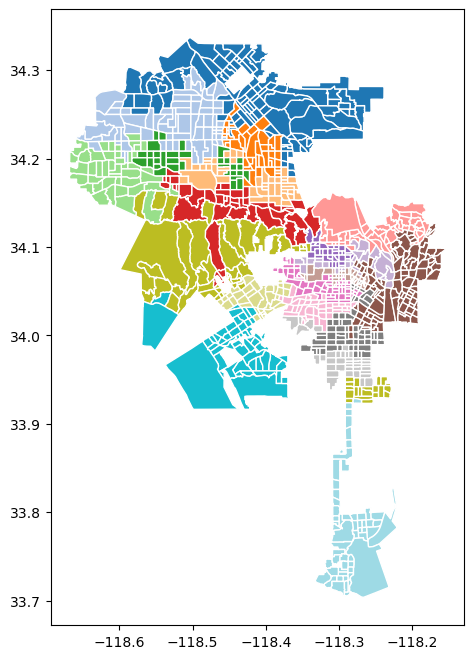

In [20]:
lacity["regionLabel"] = regions
lacity.plot(column = "regionLabel", cmap="tab20", edgecolor="w", figsize = (12, 8))